In [15]:
# -------------------------------
# Imports
# -------------------------------
import numpy as np
import pandas as pd
import xgboost as xgb
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, roc_auc_score
import time
import gc
import warnings
warnings.filterwarnings('ignore')

# -------------------------------
# Load Data
# -------------------------------
X_train = pd.read_csv('../data/X_train_encoded.csv')
X_test  = pd.read_csv('../data/X_test_encoded.csv')
y_train = pd.read_csv('../data/y_train.csv')
y_test  = pd.read_csv('../data/y_test.csv')

# Flatten target if needed
# Map target to numeric
y_train_numeric = y_train['Target'].map({'Low': 0, 'Medium': 1, 'High': 2})
y_test_numeric = y_test['Target'].map({'Low': 0, 'Medium': 1, 'High': 2})


num_classes = len(np.unique(y_train_numeric))
print(f"Number of classes: {num_classes}")


Number of classes: 3


In [16]:
X_train.shape

(15072, 145)

In [19]:

# -------------------------------
# Optuna objective for XGBoost
# -------------------------------
def objective(trial):

    param = {
            'objective': 'multi:softprob',  # multiclass probability output
            'num_class': num_classes,
            'eval_metric': 'mlogloss',
            'tree_method':'hist', # hist
            'grow_policy': 'lossguide',
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.9, log=True),
            'max_depth': trial.suggest_int('max_depth', 2, 17),
            'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 1e3, log=True),
            'subsample': trial.suggest_float('subsample', 0.4, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
            'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 1e-8, 10.0, log=True),
            'reg_alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
            'reg_lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
            'verbosity': 0,
            'random_state': trial.suggest_categorical('random_state', [2026]),
        }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    logloss_scores = []



    for train_idx, valid_idx in skf.split(X_train, y_train_numeric):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train_numeric[train_idx], y_train_numeric[valid_idx]

        dtrain = xgb.DMatrix(X_tr, label=y_tr)
        dvalid = xgb.DMatrix(X_val, label=y_val)

        bst = xgb.train(
            params=param,
            dtrain=dtrain,
            num_boost_round=5000,
            evals=[(dvalid, 'valid')],
            early_stopping_rounds=100,
            verbose_eval=False,
            callbacks=[optuna.integration.XGBoostPruningCallback(trial, "valid-mlogloss")]
        )

        pred_val = bst.predict(dvalid)
        fold_logloss = log_loss(y_val, pred_val)
        logloss_scores.append(fold_logloss)

        trial.report(fold_logloss, step=len(logloss_scores))
        if trial.should_prune():
            raise optuna.TrialPruned()

    return np.mean(logloss_scores)



In [20]:
# -------------------------------
# Optuna study
# -------------------------------
debug = True
timeout = 60 if debug else 3600  # 1 min for debug, 1 hour for full run

start = time.time()
sampler = optuna.samplers.TPESampler(
    n_startup_trials=30,  # first 30 trials are purely random (explore full space)
    multivariate=True      # consider correlations between parameters
)

pruner = optuna.pruners.SuccessiveHalvingPruner(
    min_resource=2,
    reduction_factor=4,
    min_early_stopping_rate=1
)

study = optuna.create_study(
    direction='minimize',
    sampler=sampler,
    pruner=pruner
)
study.optimize(objective, n_trials=30, timeout=3600)  # increase n_trials for ultra-wide search
end = time.time()

print(f"Optuna finished in {end - start:.2f} seconds")
print("Best params:", study.best_params)
print("Best CV multi_logloss:", study.best_value)

# -------------------------------
# Train final XGBoost model
# -------------------------------
best_params = study.best_params
best_params.update({
    'objective': 'multi:softprob',
    'num_class': num_classes,
    'eval_metric': 'mlogloss',
    'verbosity': 1
})

dtrain_full = xgb.DMatrix(X_train, label=y_train_numeric)
dtest_full  = xgb.DMatrix(X_test, label=y_test_numeric)

print("\nTraining final model on full training data...")
final_model = xgb.train(
    params=best_params,
    dtrain=dtrain_full,
    num_boost_round=5000,
    evals=[(dtest_full, 'test')],
    early_stopping_rounds=100,
    verbose_eval=100
)

# -------------------------------
# Evaluate on test set
# -------------------------------
pred_test = final_model.predict(dtest_full)
y_test_arr = np.array(y_test_numeric).flatten()

roc_auc = roc_auc_score(y_test_arr, pred_test, multi_class='ovr', average='weighted')
logloss = log_loss(y_test_arr, pred_test)
accuracy = np.mean(np.argmax(pred_test, axis=1) == y_test_arr)

print("\n--- Test set performance ---")
print(f"ROC AUC (OVR weighted): {roc_auc:.5f}")
print(f"Log Loss:           {logloss:.5f}")
print(f"Accuracy:           {accuracy:.5f}")

gc.collect()


[I 2026-01-03 01:25:28,257] A new study created in memory with name: no-name-d77d3ab4-168d-492a-a2d7-fe7bd0f9f5bf
[I 2026-01-03 01:26:50,666] Trial 0 finished with value: 0.4482992233096583 and parameters: {'learning_rate': 0.2319256793163593, 'max_depth': 15, 'min_child_weight': 790.7054211805627, 'subsample': 0.6744817496800948, 'colsample_bytree': 0.9719162482016859, 'colsample_bylevel': 0.5476934090380996, 'gamma': 5.104806699218037, 'alpha': 0.012097711626562358, 'lambda': 1.15825970062941, 'random_state': 2026}. Best is trial 0 with value: 0.4482992233096583.
[I 2026-01-03 01:31:10,477] Trial 1 finished with value: 0.1911902843697321 and parameters: {'learning_rate': 0.10116869890382564, 'max_depth': 8, 'min_child_weight': 88.25645056998945, 'subsample': 0.8556806681959342, 'colsample_bytree': 0.641259902016565, 'colsample_bylevel': 0.7454371930240333, 'gamma': 2.0954951309380598e-06, 'alpha': 0.0014858494785443873, 'lambda': 0.0035688865616209956, 'random_state': 2026}. Best is 

Optuna finished in 606.44 seconds
Best params: {'learning_rate': 0.22756001233126608, 'max_depth': 15, 'min_child_weight': 1.6951285616057659, 'subsample': 0.4258859815176049, 'colsample_bytree': 0.7562192894146758, 'colsample_bylevel': 0.8310242267144476, 'gamma': 0.01425483621832218, 'alpha': 0.06406624088023742, 'lambda': 0.14252405470923735, 'random_state': 2026}
Best CV multi_logloss: 0.18996020893153748

Training final model on full training data...
[0]	test-mlogloss:0.88572
[100]	test-mlogloss:0.38534
[122]	test-mlogloss:0.39171

--- Test set performance ---
ROC AUC (OVR weighted): 0.93515
Log Loss:           0.39171
Accuracy:           0.87734


47

In [20]:
import optuna.visualization as vis



# Slice plot for individual params
vis.plot_slice(study)


In [21]:
vis.plot_param_importances(study)


In [24]:
# Parallel coordinate plot of top trials
vis.plot_parallel_coordinate(study)

In [23]:
vis.plot_contour(study)

[W 2026-01-02 16:39:11,893] Param random_state unique value length is less than 2.
[W 2026-01-02 16:39:11,897] Param random_state unique value length is less than 2.
[W 2026-01-02 16:39:11,898] Param random_state unique value length is less than 2.
[W 2026-01-02 16:39:11,900] Param random_state unique value length is less than 2.
[W 2026-01-02 16:39:11,902] Param random_state unique value length is less than 2.
[W 2026-01-02 16:39:11,904] Param random_state unique value length is less than 2.
[W 2026-01-02 16:39:11,905] Param random_state unique value length is less than 2.
[W 2026-01-02 16:39:11,906] Param random_state unique value length is less than 2.
[W 2026-01-02 16:39:11,906] Param random_state unique value length is less than 2.
[W 2026-01-02 16:39:11,907] Param random_state unique value length is less than 2.
[W 2026-01-02 16:39:11,908] Param random_state unique value length is less than 2.
[W 2026-01-02 16:39:11,909] Param random_state unique value length is less than 2.
[W 2

In [11]:
vis.plot_optimization_history(study)

In [12]:
vis.plot_intermediate_values(study)

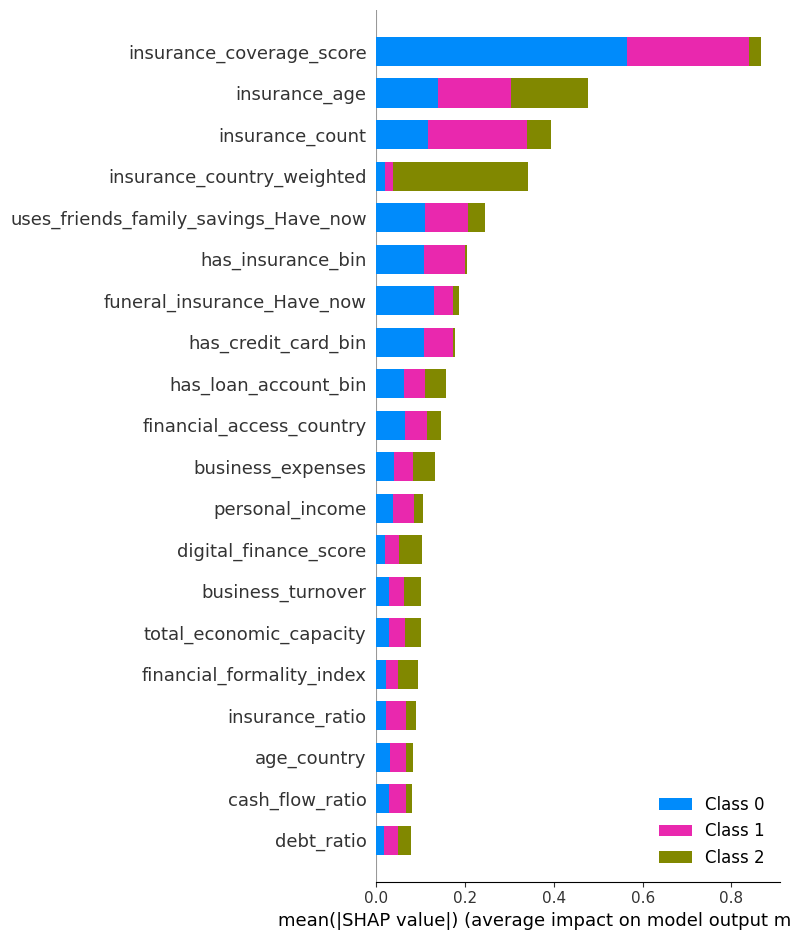

In [ ]:
import shap
import numpy as np
X_shap = X_train.sample(1000, random_state=42)  # reduce if slow
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_shap)
shap.summary_plot(
    shap_values,
    X_shap,
    plot_type="bar",
    class_names=[f"Class {i}" for i in range(len(shap_values))]
)